In [ ]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from statsmodels.tsa.seasonal import STL # For Time Series Decomposition Analysis

In [ ]:
# Load the data from the uploaded CSV file
try:
    df = pd.read_csv('Nat_Gas.csv')
    print("Data loaded successfully.")

    # Preprocessing
    df['Dates'] = pd.to_datetime(df['Dates'])
    df = df.set_index('Dates')
    # Resample to the end of the month ('M') to ensure regular monthly frequency
    df = df.resample('M').last()

    print("\nProcessed Data Head:")
    print(df.head())
    print("\nProcessed Data Info:")
    print(df.info())

except FileNotFoundError:
    print("Error: Nat_Gas.csv not found. Please upload the file to your Colab environment's session storage.")
    exit()

Data loaded successfully.

Processed Data Head:
            Prices
Dates             
2020-10-31    10.1
2020-11-30    10.3
2020-12-31    11.0
2021-01-31    10.9
2021-02-28    10.9

Processed Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2020-10-31 to 2024-09-30
Freq: ME
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Prices  48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes
None


/tmp/ipython-input-332408625.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dates'] = pd.to_datetime(df['Dates'])
/tmp/ipython-input-332408625.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').last()


Generating STL Decomposition Plot...


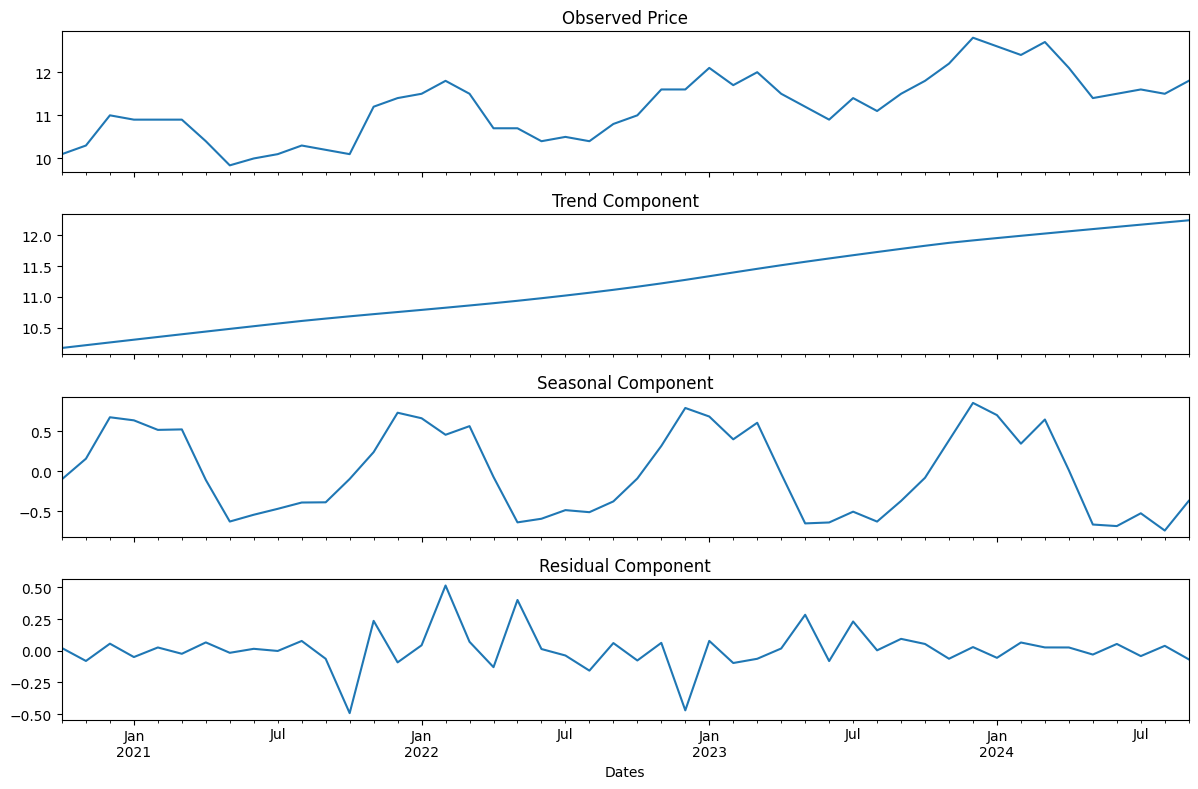

In [ ]:
print("Generating STL Decomposition Plot...")
try:
    # STL Decomposition (Visual analysis of components)
    stl = STL(df['Prices'], seasonal=13, robust=True)
    result = stl.fit()
    fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 8))
    result.observed.plot(ax=axes[0], title='Observed Price')
    result.trend.plot(ax=axes[1], title='Trend Component')
    result.seasonal.plot(ax=axes[2], title='Seasonal Component')
    result.resid.plot(ax=axes[3], title='Residual Component')
    plt.tight_layout()
    plt.savefig('nat_gas_stl_decomposition.png')
    plt.show()

except Exception as e:
    print(f"Warning: STL decomposition failed: {e}.")

Generating Monthly Boxplot for Seasonality Check...


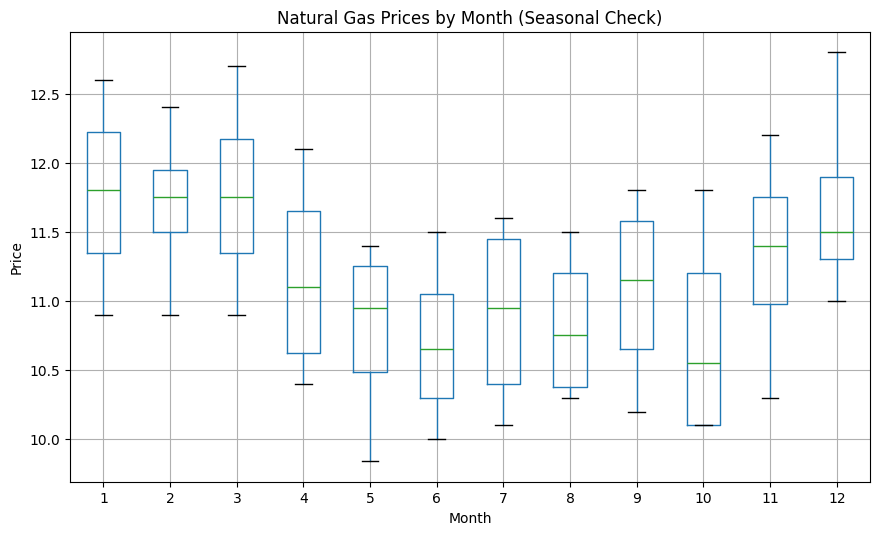

In [ ]:
print("Generating Monthly Boxplot for Seasonality Check...")
# Box plot for monthly seasonality check
df_monthly = df.copy()
df_monthly['Month'] = df_monthly.index.month # 'Month' is added only to the temporary copy

plt.figure(figsize=(10, 6))
# Boxplot uses the temporary df_monthly copy
df_monthly.boxplot(column='Prices', by='Month', ax=plt.gca())
plt.title('Natural Gas Prices by Month (Seasonal Check)')
plt.suptitle('')
plt.xlabel('Month')
plt.ylabel('Price')
plt.grid(True)
plt.savefig('nat_gas_monthly_boxplot.png')
plt.show()

# The line to drop 'Month' from df has been REMOVED,
# as 'Month' was not added to df in this block.

In [ ]:
print("Calculating Seasonal Index and Linear Trend...")

#Seasonal Index Calculation
df['Month'] = df.index.month
monthly_avg = df.groupby('Month')['Prices'].mean()
overall_avg = df['Prices'].mean()
# Seasonal Index = (Monthly Avg Price) / (Overall Avg Price)
seasonal_index = monthly_avg / overall_avg
df = df.drop(columns='Month')

print("\nSeasonal Indices (used to adjust forecast):")
print(seasonal_index)

#Trend Calculation
# Convert dates to numerical time steps (0, 1, 2, ...)
time_steps = np.arange(len(df))
# Linear fit: y = m*x + c
trend_fit = np.polyfit(time_steps, df['Prices'], 1)
trend_line = np.poly1d(trend_fit)

print(f"\nCalculated Linear Trend: Price = {trend_fit[0]:.4f} * Time_Step + {trend_fit[1]:.4f}")

Calculating Seasonal Index and Linear Trend...

Seasonal Indices (used to adjust forecast):
Month
1     1.050675
2     1.043983
3     1.050675
4     0.997137
5     0.962338
6     0.954753
7     0.972599
8     0.965907
9     0.988214
10    0.959215
11    1.010522
12    1.043983
Name: Prices, dtype: float64

Calculated Linear Trend: Price = 0.0390 * Time_Step + 10.2903


In [ ]:
print("Generating 1-Year Forecast and Daily Interpolation (Simplified)...")

#Extrapolate Trend and Apply Seasonal Adjustment
last_date = df.index.max()
# Generate 12 months of future dates for the forecast
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=12, freq='M').normalize()

# Forecast Trend Time Steps
historical_steps = len(df)
forecast_steps = np.arange(historical_steps, historical_steps + 12)

#Calculate the Seasonally Adjusted Forecast Prices
forecast_prices = [
    trend_line(step) * seasonal_index.loc[date.month]
    for step, date in zip(forecast_steps, forecast_dates)
]

# Create the forecast series
forecast_series = pd.Series(forecast_prices, index=forecast_dates, name='Prices')


#Combine and Daily Interpolate
# Combine historical (df['Prices']) and the new forecast series
master_series = pd.concat([df['Prices'], forecast_series])

# Daily Interpolation across the entire series (historical + forecast) to fill in daily estimates
master_series = master_series.resample('D').interpolate(method='linear')

print("\nForecasted Monthly Prices (First 5 Months):")
# Use the un-interpolated monthly forecast for a clean look at the forecast points
print(forecast_series.head())

Generating 1-Year Forecast and Daily Interpolation (Simplified)...

Forecasted Monthly Prices (First 5 Months):
2024-10-31    11.666841
2024-11-30    12.330305
2024-12-31    12.779322
2025-01-31    12.902231
2025-02-28    12.860781
Freq: ME, Name: Prices, dtype: float64


/tmp/ipython-input-3861784432.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=12, freq='M').normalize()



Generating Final Forecast Visualization...


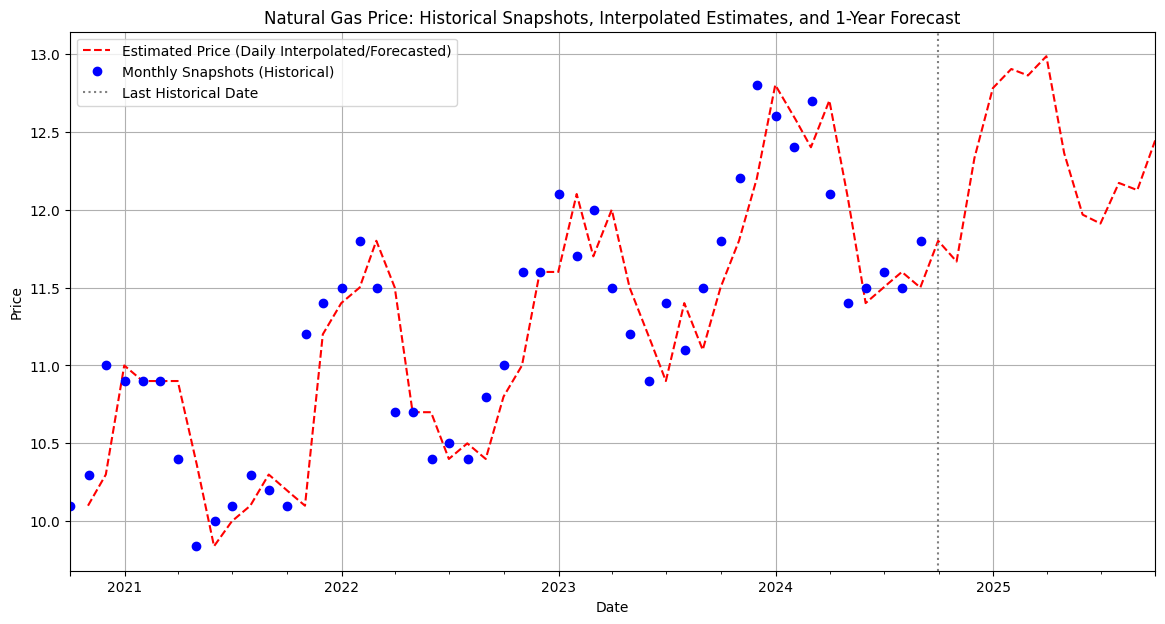

In [ ]:
# --- Define the Interpolator ---
x = master_series.index.astype(np.int64) // 10**9 # Convert datetime index to seconds
y = master_series.values
f = interp1d(x, y, kind='linear', fill_value='extrapolate')

def estimate_price(date_str):
    """
    Estimates the natural gas purchase price for a given date using the interpolated master series.
    """
    try:
        date_obj = pd.to_datetime(date_str)
        date_numeric = date_obj.timestamp()
        estimated_price = f(date_numeric)

        if date_obj < master_series.index.min() or date_obj > master_series.index.max():
             pass # Extrapolation warning suppressed for cleaner contract output

        return float(estimated_price)
    except Exception as e:
        print(f"Error processing date '{date_str}': {e}")
        return 0.0

# --- Final Visualization ---
print("\nGenerating Final Forecast Visualization...")
plt.figure(figsize=(14, 7))
master_series.plot(label='Estimated Price (Daily Interpolated/Forecasted)', color='red', linestyle='--')
df['Prices'].plot(style='o', label='Monthly Snapshots (Historical)', color='blue')

plt.title('Natural Gas Price: Historical Snapshots, Interpolated Estimates, and 1-Year Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.axvline(df.index.max(), color='grey', linestyle=':', label='Last Historical Date')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# --- Define Contract Pricing Function ---

def price_storage_contract(
    estimate_price_func,    # The price estimator function (i.e., 'estimate_price')
    injection_dates,        # List of date strings for injection/purchase
    withdrawal_dates,       # List of date strings for withdrawal/sale
    rate_mmbtu_per_day,     # Injection/Withdrawal Rate (MMBtu/day)
    max_volume_mmbtu,       # Maximum Storage Capacity (MMBtu)
    storage_cost_total      # Total Fixed Cost for Storage Capacity ($)
):
    """
    Calculates the value of a natural gas storage contract based on commodity price
    differences and fixed storage costs. (Assumes zero interest rates).
    """

    # 1. Calculate Injection Costs (Cash Outflow, Negative CF)
    injection_cost = 0.0
    total_injected_volume = 0.0

    for date_str in injection_dates:
        price = estimate_price_func(date_str)
        injection_cost += rate_mmbtu_per_day * price
        total_injected_volume += rate_mmbtu_per_day

    # 2. Calculate Withdrawal Revenue (Cash Inflow, Positive CF)
    withdrawal_revenue = 0.0
    total_withdrawn_volume = 0.0

    for date_str in withdrawal_dates:
        price = estimate_price_func(date_str)
        withdrawal_revenue += rate_mmbtu_per_day * price
        total_withdrawn_volume += rate_mmbtu_per_day

    # 3. Calculate Final Contract Value
    net_trading_cf = withdrawal_revenue - injection_cost
    contract_value = net_trading_cf - storage_cost_total

    # --- Output Summary ---
    print(f"\n--- Contract Cash Flow Summary ---")
    print(f"Injected Volume: {total_injected_volume:,.0f} MMBtu | Withdrawn Volume: {total_withdrawn_volume:,.0f} MMBtu")
    print(f"Total Injection Cost (Purchase):   $-{injection_cost:,.2f}")
    print(f"Total Withdrawal Revenue (Sale):   $+{withdrawal_revenue:,.2f}")
    print(f"Total Net Trading CF:              ${net_trading_cf:,.2f}")
    print(f"Total Storage Cost:                $-{storage_cost_total:,.2f}")

    # Basic Validation Check
    if total_injected_volume > max_volume_mmbtu:
        print(f"!!! WARNING: Injected Volume ({total_injected_volume:,.0f} MMBtu) exceeds Capacity ({max_volume_mmbtu:,.0f} MMBtu).")

    return contract_value

# --- Test Scenarios ---

# Scenario 1: Seasonal Spread Trade (Buy Low, Sell High)
INJ_DATES_1 = ['2024-07-31', '2024-08-31', '2024-09-30']
WDR_DATES_1 = ['2025-01-31', '2025-02-28', '2025-03-31']
RATE_1 = 5000
V_MAX_1 = 20000
COST_1 = 15000

print("\n\n#####################################################")
print("SCENARIO 1: Seasonal Spread Trade (Buy Summer / Sell Winter)")
value_1 = price_storage_contract(estimate_price, INJ_DATES_1, WDR_DATES_1, RATE_1, V_MAX_1, COST_1)
print(f"FINAL CONTRACT VALUE:              ${value_1:,.2f}")
print("#####################################################")


# Scenario 2: Forward Spread Trade with Higher Costs
INJ_DATES_2 = ['2025-04-15', '2025-05-15']
WDR_DATES_2 = ['2025-05-31', '2025-06-30']
RATE_2 = 10000
V_MAX_2 = 30000
COST_2 = 30000

print("\n\n#####################################################")
print("SCENARIO 2: Forward Spread Trade (Buy Spring / Sell Early Summer)")
value_2 = price_storage_contract(estimate_price, INJ_DATES_2, WDR_DATES_2, RATE_2, V_MAX_2, COST_2)
print(f"FINAL CONTRACT VALUE:              ${value_2:,.2f}")
print("#####################################################")



#####################################################
SCENARIO 1: Seasonal Spread Trade (Buy Summer / Sell Winter)

--- Contract Cash Flow Summary ---
Injected Volume: 15,000 MMBtu | Withdrawn Volume: 15,000 MMBtu
Total Injection Cost (Purchase):   $-174,500.00
Total Withdrawal Revenue (Sale):   $+193,736.12
Total Net Trading CF:              $19,236.12
Total Storage Cost:                $-15,000.00
FINAL CONTRACT VALUE:              $4,236.12
#####################################################


#####################################################
SCENARIO 2: Forward Spread Trade (Buy Spring / Sell Early Summer)

--- Contract Cash Flow Summary ---
Injected Volume: 20,000 MMBtu | Withdrawn Volume: 20,000 MMBtu
Total Injection Cost (Purchase):   $-248,437.73
Total Withdrawal Revenue (Sale):   $+238,781.94
Total Net Trading CF:              $-9,655.79
Total Storage Cost:                $-30,000.00
FINAL CONTRACT VALUE:              $-39,655.79
#######################################